__поиск объекта на изображении по особым точкам__

Евгений Борисов borisov.e@solarl.ru

In [1]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter
from matplotlib import pyplot as plt

In [2]:
print('OpenCV ',cv2.__version__)

OpenCV  4.5.1


----

In [3]:
!ls ../data/sift-matcher/obj/

bona.png   cola2.png  cola4.png  fant.png  monst1.png  nest.png
cola1.png  cola3.png  cola5.png  jelt.png  monst2.png  spri.png


In [4]:
MIN_MATCH_COUNT = 10 # порог минимального количества совпадений ключевых точек
DIST_COEFF = 0.65

test_image_file = '../data/sift-matcher/test.jpg'  
obj_image_file = '../data/sift-matcher/obj/cola5.png' 

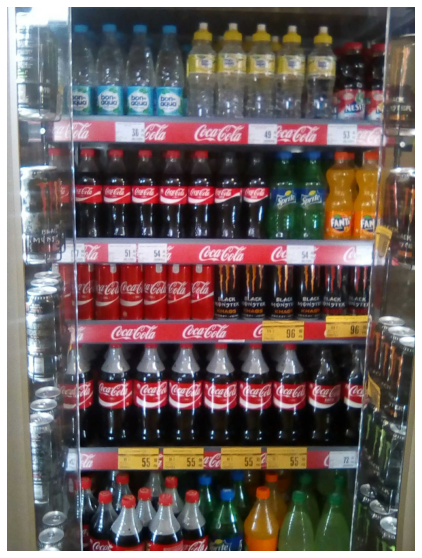

In [5]:
plt.figure(figsize=(10,10))
plt.axis(False)
plt.imshow(cv2.cvtColor(cv2.imread(test_image_file),cv2.COLOR_BGR2RGB))

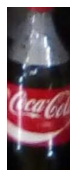

In [6]:
plt.figure(figsize=(3,3))
plt.axis(False)
plt.imshow(cv2.cvtColor(cv2.imread(obj_image_file),cv2.COLOR_BGR2RGB))

In [7]:
# для демонстрации возможнстей метода изменим исходную картинку
def load_img_big(f):
    img1 = cv2.imread(f,cv2.IMREAD_GRAYSCALE)

    # поворачиваем и масштабируем основную картинку
    dsize = ( int(img1.shape[1] * 0.4), int(img1.shape[0] * 0.4) )
    img1 = cv2.resize(src=img1,dsize=dsize, interpolation = cv2.INTER_CUBIC)
    rows,cols = img1.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),14,1)
    img1 = cv2.warpAffine(img1,M,(cols,rows))

    return  img1

In [9]:
# считываем картинку и ищем особые точки
img_big = load_img_big(test_image_file)
# sift = cv2.xfeatures2d.SIFT_create() 
sift = cv2.SIFT_create() 
kp_big, des_big = sift.detectAndCompute(img_big,None)

# считываем картинку с объектом и ищем особые точки
img_tpl = cv2.imread(obj_image_file,cv2.IMREAD_GRAYSCALE)  
kp_tpl, des_tpl = sift.detectAndCompute(img_tpl,None)

# сопоставляем особые точки
matcher = cv2.BFMatcher() 
matches = matcher.knnMatch(des_tpl,des_big,k=2)

good = []
for m,n in matches:
    if m.distance < n.distance * DIST_COEFF: 
        good.append(m)

if len(good)<MIN_MATCH_COUNT:
    print( "[w] количество совпадений недостаточно - %d/%d" % (len(good),MIN_MATCH_COUNT) )
else:    
    print( "[i] найдено %d совпадений" % len(good) )

    src_pts = np.float32([ kp_tpl[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_big[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # матрица преобразования координат точек
    M, mask = cv2.findHomography( src_pts, dst_pts, cv2.RANSAC , 5.0 ) 

    # координаты точек рамки шаблона 
    h,w = img_tpl.shape # размеры шаблона
    pts = np.asarray( [ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ], dtype=np.float32).reshape(-1,1,2)

    # выполняем преобразования координат точек рамки шаблона
    dst = cv2.perspectiveTransform( pts, M )

    dst = [np.int32(np.abs(dst))] # обрезаем рамку вылезшую за пределы картинки 

    # рисуем рамку вокруг найденного объекта
    img_res =  cv2.cvtColor(img_big, cv2.COLOR_GRAY2BGR) 
    img_res = cv2.polylines( img_res, dst, True, (0,255,255), 2, cv2.LINE_AA )

    # рисуем совпадения контрольных точек 
    matchesMask = mask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    img_res = cv2.drawMatches( img_tpl, kp_tpl, img_res, kp_big, good, None, **draw_params )

[i] найдено 39 совпадений


----

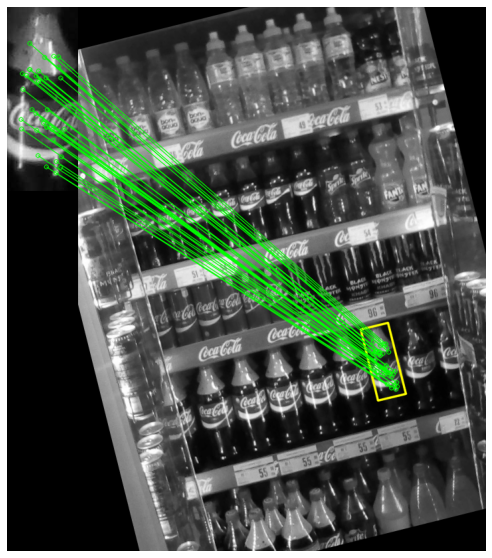

In [10]:
plt.figure(figsize=(10,10))
plt.axis(False)
plt.imshow(cv2.cvtColor(img_res,cv2.COLOR_BGR2RGB) )